In [1]:
%pylab nbagg
%load_ext autoreload
%autoreload 2
import mpl_interactions as pli

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Test the fastcat mhd file reader from fastcat.utils
import fastcat as fc
import numpy as np
import matplotlib.pyplot as plt
import fastcat.ggems_scatter as gg_scatter


# Read the mhd file from data
mhd_file = '/home/jericho/1-Workspace/fastcat_gate/Catphan604.mhd'
range_file = '/home/jericho/1-Workspace/fastcat_gate/Catphan604_Range.txt'
material_file = '/home/jericho/1-Workspace/fastcat_gate/Materials.txt'

Catphan604_phantom = fc.utils.get_phantom_from_mhd(mhd_file,range_file,material_file)

s = fc.spectrum.Spekpy(120,12)

# Make a dummy spectrum
s.x = np.array([99.999, 100, 100.001])
s.y = np.array([0,1,0])
# s.attenuate(0.4,fc.get_mu(z=13))
det = fc.Detector(s,'CsI-784-micrometer')
angles = np.linspace(0,np.pi*2,10,endpoint=False)   

[2023-11-13 09:59:14,630] {utils.py:231} INFO - Loading density data from file
[2023-11-13 09:59:14,632] {utils.py:321} INFO -     Saved Air atten to file in data/mu/Air.csv
[2023-11-13 09:59:14,633] {utils.py:321} INFO -     Saved polyurethane atten to file in data/mu/polyurethane.csv
[2023-11-13 09:59:14,634] {utils.py:321} INFO -     Saved teflon atten to file in data/mu/teflon.csv
[2023-11-13 09:59:14,635] {utils.py:321} INFO -     Saved pmp atten to file in data/mu/pmp.csv
[2023-11-13 09:59:14,636] {utils.py:321} INFO -     Saved bone50 atten to file in data/mu/bone50.csv
[2023-11-13 09:59:14,637] {utils.py:321} INFO -     Saved ldpe atten to file in data/mu/ldpe.csv
[2023-11-13 09:59:14,638] {utils.py:321} INFO -     Saved polystyrene atten to file in data/mu/polystyrene.csv
[2023-11-13 09:59:14,642] {utils.py:321} INFO -     Saved acrylic atten to file in data/mu/acrylic.csv
[2023-11-13 09:59:14,643] {utils.py:321} INFO -     Saved bone20 atten to file in data/mu/bone20.csv
[202

In [3]:
Catphan604_phantom.return_projs(det,s,angles, 
                                mgy=0, ASG=False,scat_on=False,
                                det_on=False,bowtie=False,
                                filter='bowtie_real',return_intensity=True)

[2023-11-13 09:59:19,740] {simulate.py:221} INFO - Initializing filter bowtie_real
[2023-11-13 09:59:19,770] {simulate.py:476} INFO -     Interp scatter 512 to 512 pixels
[2023-11-13 09:59:19,771] {simulate.py:476} INFO -     Interp scatter 512 to 512 pixels
[2023-11-13 09:59:20,541] {simulate.py:579} INFO - Running Simulations
[2023-11-13 09:59:20,541] {simulate.py:606} INFO -     Simulating 100 keV
[2023-11-13 09:59:21,392] {simulate.py:821} INFO - Weighting simulations
[2023-11-13 09:59:21,397] {simulate.py:904} INFO -     No noise was added


In [6]:
import SimpleITK as sitk
import numpy as np
'''
This funciton reads a '.mhd' file using SimpleITK and return the image array, origin and spacing of the image.
'''

def load_itk(filename):
    '''
    :param filename: path to the .mhd file
    Returns: ct_scan, origin, spacing
    '''
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage).squeeze()

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return ct_scan, origin, spacing

### Compare fastcat to ggems 

<IPython.core.display.Javascript object>


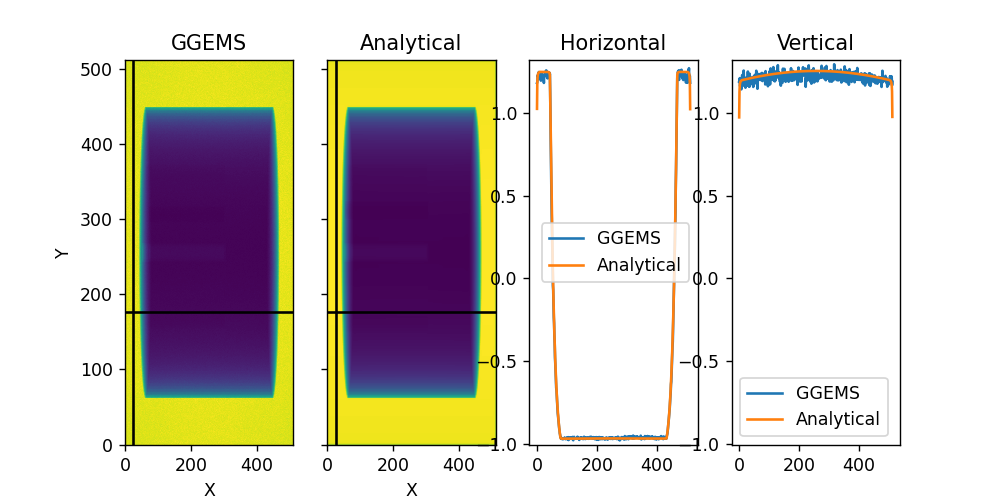

<IPython.core.display.Javascript object>


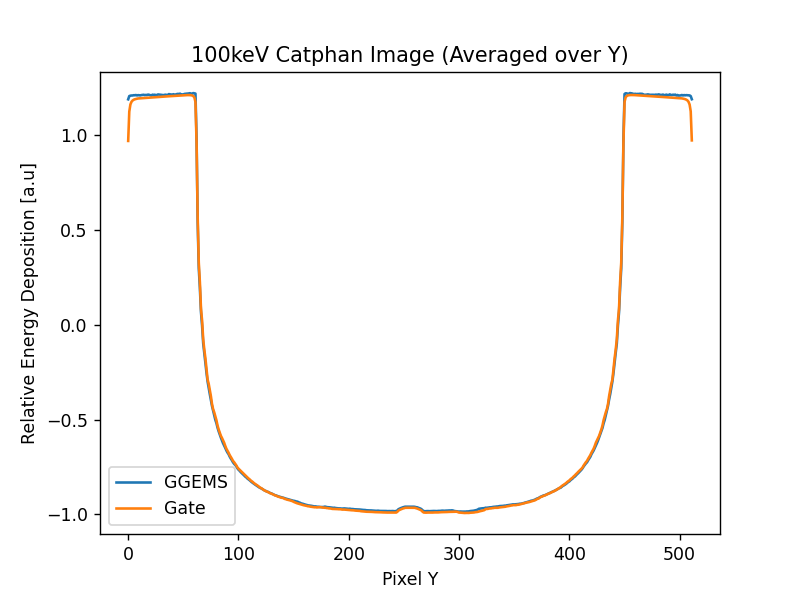

<IPython.core.display.Javascript object>


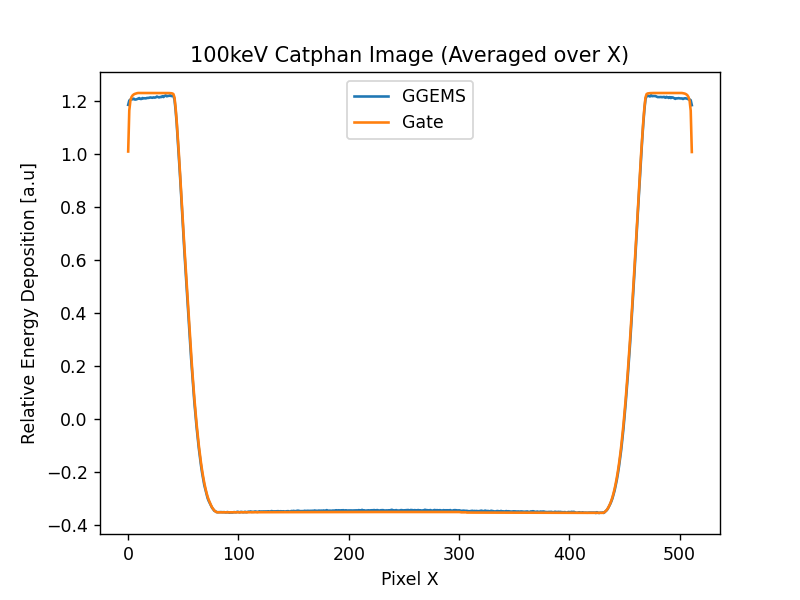

In [18]:
fastcat_norm = (Catphan604_phantom.intensity[0] - np.mean(Catphan604_phantom.intensity[0]))/np.std(Catphan604_phantom.intensity[0])
ggems_image, origin, space = load_itk('/home/jericho/1-Workspace/opengate_ggems_comparison/water_cylinder/out/run_1e10.mhd') # What is this in? - Should be MeV as well according to didier
scatter_image, origin, space = load_itk('/home/jericho/1-Workspace/opengate_ggems_comparison/water_cylinder/out/run_1e10-scatter.mhd')

ggems_image2 = ggems_image - scatter_image
ggems_norm = (ggems_image2 - np.mean(ggems_image2))/np.std(ggems_image2)

pli.heatmap_slicer(range(ggems_norm.shape[0]),range(ggems_norm.shape[1]),
                   [ggems_norm,np.rot90(fastcat_norm,3)],figsize=[8,4],heatmap_names=['GGEMS','Analytical'],slices='both')

plt.figure()
plt.title('100keV Catphan Image (Averaged over Y)')
plt.plot(np.mean(ggems_norm[:,100:-100],axis=1))
plt.plot(np.mean(np.rot90(fastcat_norm,3)[:,100:-100],axis=1))
plt.ylabel('Relative Energy Deposition [a.u]')
plt.xlabel('Pixel Y')
plt.legend(['GGEMS','Gate'])

plt.figure()
plt.title('100keV Catphan Image (Averaged over X)')
plt.plot(np.mean(ggems_norm[:-250,:],axis=0))
plt.plot(np.mean(np.rot90(fastcat_norm,3)[:-250,:],axis=0))
plt.ylabel('Relative Energy Deposition [a.u]')
plt.xlabel('Pixel X')

plt.legend(['GGEMS','Gate'])

### Compare ggems to ggems 

<IPython.core.display.Javascript object>


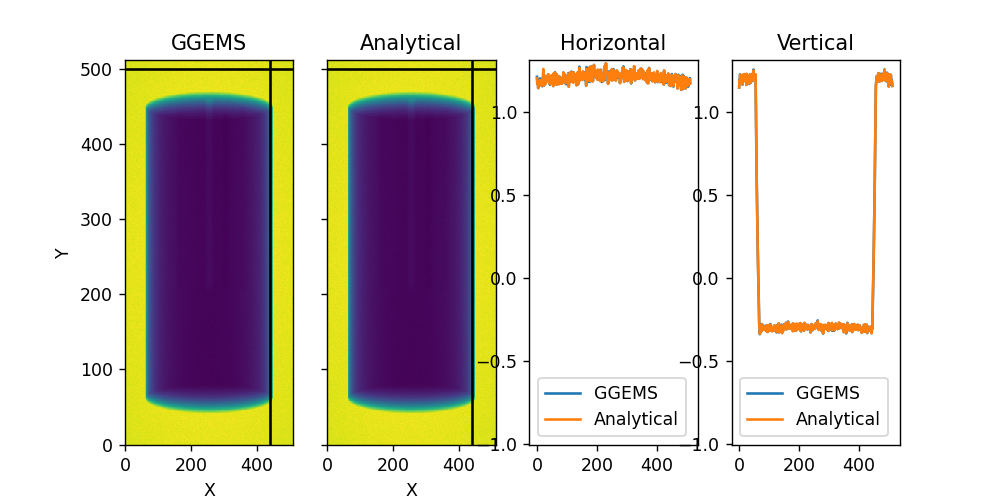

<IPython.core.display.Javascript object>


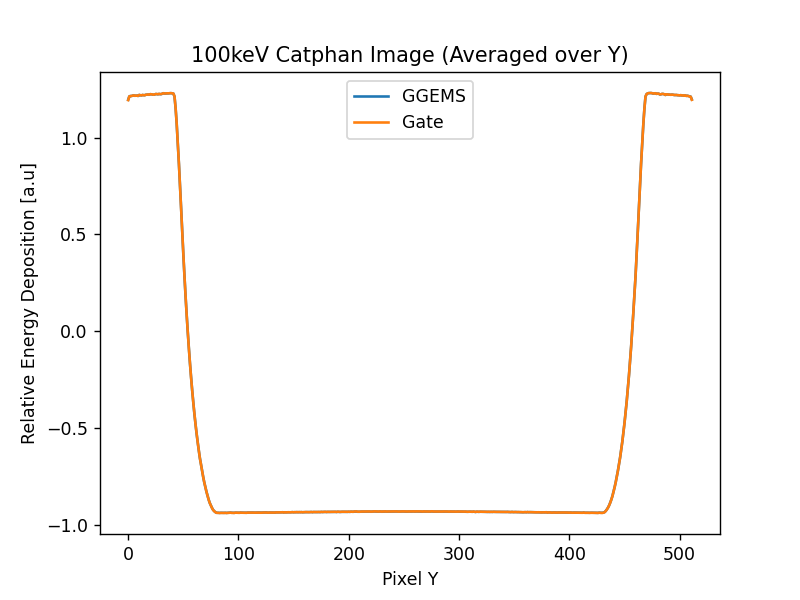

<IPython.core.display.Javascript object>


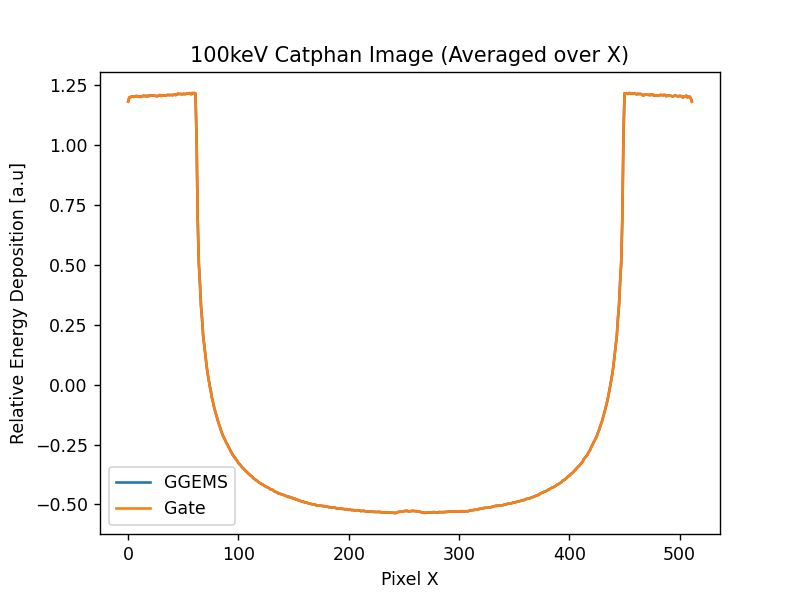

In [21]:
# fastcat_norm = (Catphan604_phantom.intensity[0] - np.mean(Catphan604_phantom.intensity[0]))/np.std(Catphan604_phantom.intensity[0])
ggems_image, origin, space = load_itk('/home/jericho/1-Workspace/opengate_ggems_comparison/water_cylinder/out/run_edep_1e10_hit.mhd') # What is this in? - Should be MeV as well according to didier
ggems_image2, origin, space = load_itk('/home/jericho/1-Workspace/opengate_ggems_comparison/water_cylinder/out/run_edep_1e10_edep.mhd')

ggems_norm = (ggems_image2 - np.mean(ggems_image2))/np.std(ggems_image2)
fastcat_norm = (ggems_image - np.mean(ggems_image))/np.std(ggems_image)

pli.heatmap_slicer(range(ggems_norm.shape[0]),range(ggems_norm.shape[1]),
                   [ggems_norm,np.rot90(fastcat_norm,0)],figsize=[8,4],heatmap_names=['GGEMS','Analytical'],slices='both')

plt.figure()
plt.title('100keV Catphan Image (Averaged over Y)')
plt.plot(np.mean(ggems_norm[:,100:-100],axis=1))
plt.plot(np.mean(np.rot90(fastcat_norm,0)[:,100:-100],axis=1))
plt.ylabel('Relative Energy Deposition [a.u]')
plt.xlabel('Pixel Y')
plt.legend(['GGEMS','Gate'])

plt.figure()
plt.title('100keV Catphan Image (Averaged over X)')
plt.plot(np.mean(ggems_norm[:-250,:],axis=0))
plt.plot(np.mean(np.rot90(fastcat_norm,0)[:-250,:],axis=0))
plt.ylabel('Relative Energy Deposition [a.u]')
plt.xlabel('Pixel X')

plt.legend(['GGEMS','Gate'])

<IPython.core.display.Javascript object>


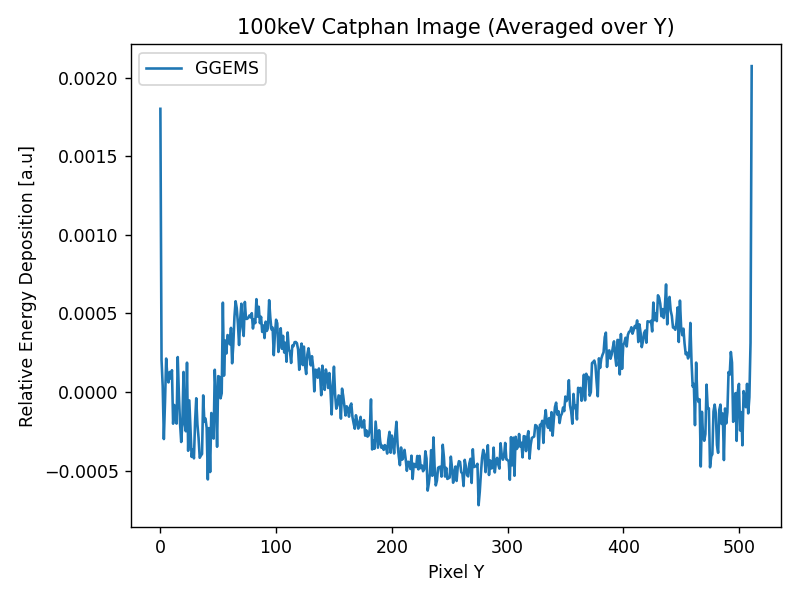

In [24]:
plt.figure()
plt.title('100keV Catphan Image (Averaged over Y)')
plt.plot(np.mean(ggems_norm[:,100:-100],axis=1) - np.mean(np.rot90(fastcat_norm,0)[:,100:-100],axis=1))
# plt.plot(np.mean(np.rot90(fastcat_norm,0)[:,100:-100],axis=1))
plt.ylabel('Relative Energy Deposition [a.u]')
plt.xlabel('Pixel Y')
plt.legend(['GGEMS','Gate'])

# plt.figure()
# plt.title('100keV Catphan Image (Averaged over X)')
# plt.plot(np.mean(ggems_norm[:-250,:],axis=0))
# plt.plot(np.mean(np.rot90(fastcat_norm,0)[:-250,:],axis=0))
# plt.ylabel('Relative Energy Deposition [a.u]')
# plt.xlabel('Pixel X')

# plt.legend(['GGEMS','Gate'])
plt.tight_layout()

<IPython.core.display.Javascript object>


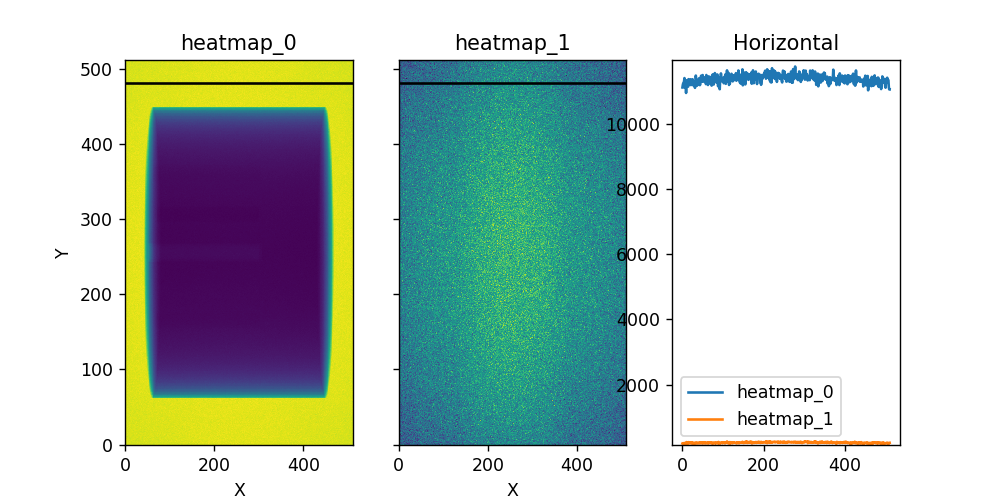

(<Figure size 800x400 with 3 Axes>,
 array([<Axes: title={'center': 'heatmap_0'}, xlabel='X', ylabel='Y'>,
        <Axes: title={'center': 'heatmap_1'}, xlabel='X'>,
        <Axes: title={'center': 'Horizontal'}>], dtype=object))

In [54]:
pli.heatmap_slicer(range(ggems_norm.shape[0]),range(ggems_norm.shape[1]),
                   [ggems_image[0],scatter_image[0]],figsize=[8,4])

In [22]:
print(Catphan604_phantom.geomet)

TIGRE parameters
-----
Geometry parameters
Distance from source to detector (DSD) = 1510 mm
Distance from source to origin (DSO)= 1000.0 mm
-----
Detector parameters
Number of pixels (nDetector) = [512 512]
Size of each pixel (dDetector) = [0.784 0.784] mm
Total size of the detector (sDetector) = [401.408 401.408] mm
-----
Image parameters
Number of voxels (nVoxel) = [400 526 526]
Total size of the image (sVoxel) = [200. 263. 263.] mm
Size of each voxel (dVoxel) = [0.5 0.5 0.5] mm
-----
Offset correction parameters
Offset of image from origin (offOrigin) = [0 0 0] mm
Offset of detector (offDetector) = [0 0] mm
-----
Auxillary parameters
Samples per pixel of forward projection (accuracy) = 0.5
-----
Rotation of the Detector (rotDetector) = [0 0 0] rad


In [41]:
read_range_file2(range_file)

(array(['Air', 'polyurethane', 'teflon', 'pmp', 'bone50', 'ldpe',
        'polystyrene', 'acrylic', 'bone20', 'pom'], dtype='<U12'),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]))

In [40]:
def read_range_file2(filename):
    """Reads a range file and returns a list of ranges"""
    materials = []
    low_range = []
    high_range = []
    with open(filename) as f:
        for line in f:
            words = line.split()
#             print(len(words))
            if len(words) == 3:
                materials.append(words[2])
                low_range.append(float(words[0]))
                high_range.append(float(words[1]))

    return np.array(materials), np.array(low_range), np.array(high_range)

In [39]:
'this has '.split()

['this', 'has']

<IPython.core.display.Javascript object>


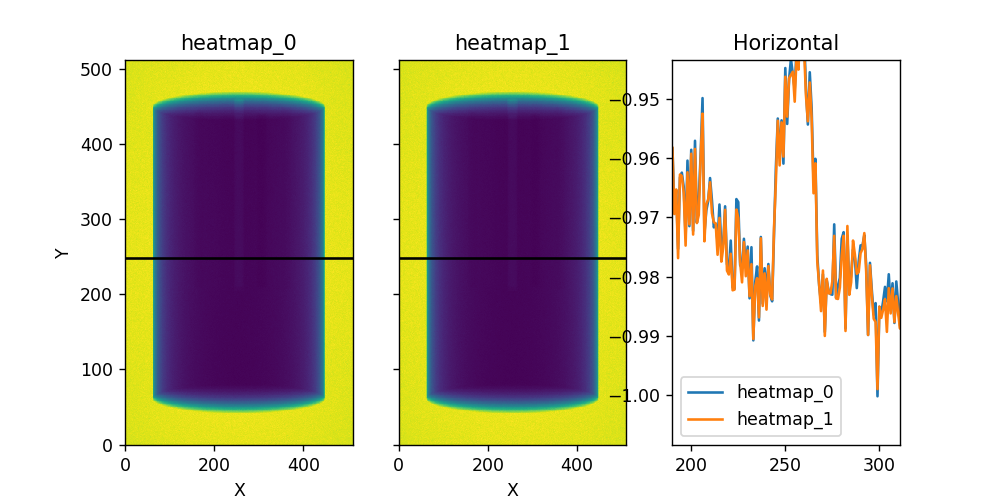

(<Figure size 800x400 with 3 Axes>,
 array([<Axes: title={'center': 'heatmap_0'}, xlabel='X', ylabel='Y'>,
        <Axes: title={'center': 'heatmap_1'}, xlabel='X'>,
        <Axes: title={'center': 'Horizontal'}>], dtype=object))

In [90]:
ggems_image, origin, space = load_itk('/home/jericho/1-Workspace/opengate_ggems_comparison/water_cylinder/run_edep_1e10_hit.mhd') # What is this in? - Should be MeV as well according to didier

ggems_image2, origin, space = load_itk('/home/jericho/1-Workspace/opengate_ggems_comparison/water_cylinder/run_edep_1e10_dose.mhd')

# ggems_image2 = ggems_image[0]
ggems_norm = (ggems_image - np.mean(ggems_image))/np.std(ggems_image)
ggems_edep_norm = (ggems_image2 - np.mean(ggems_image2))/np.std(ggems_image2)

pli.heatmap_slicer(range(ggems_norm.shape[0]),range(ggems_norm.shape[1]),
                   [ggems_norm,np.rot90(ggems_edep_norm,0)],figsize=[8,4])

# print(np.mean((ggems_norm - np.rot90(fastcat_norm,3))**2))

<IPython.core.display.Javascript object>


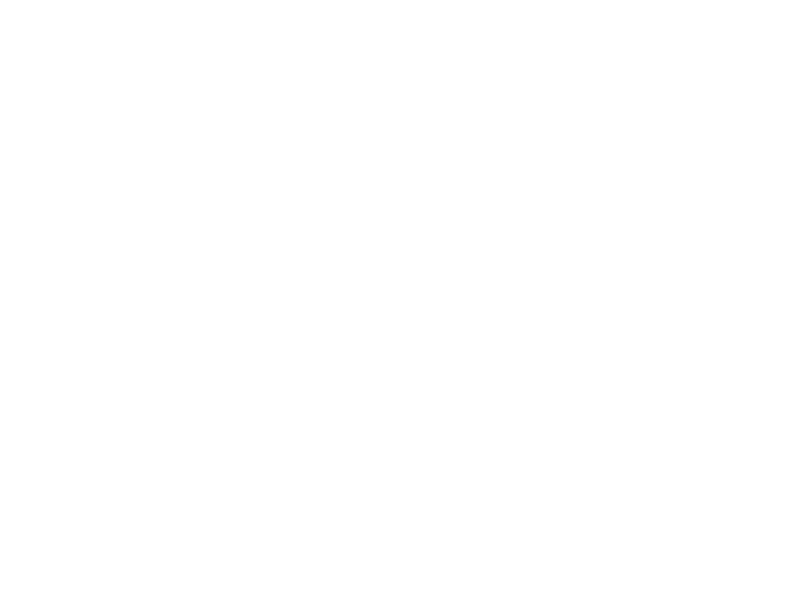

<IPython.core.display.Javascript object>


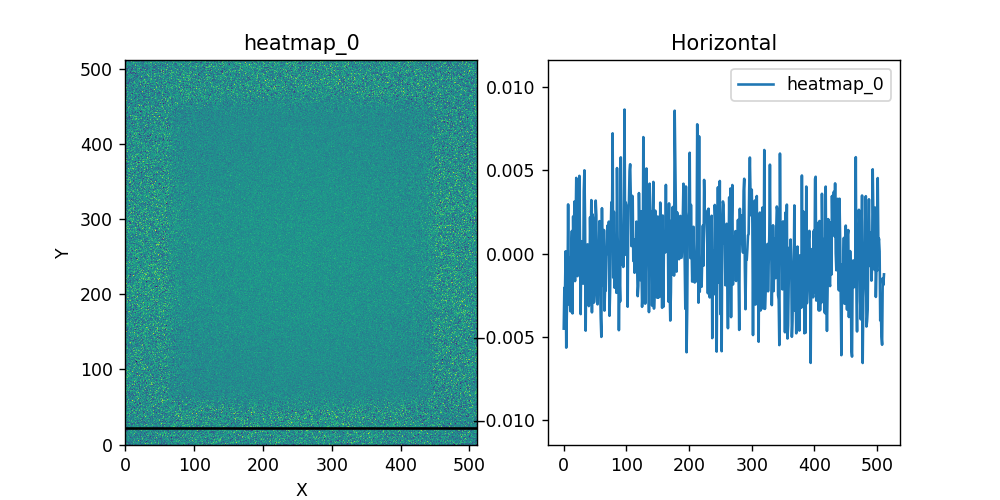

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: title={'center': 'heatmap_0'}, xlabel='X', ylabel='Y'>,
        <Axes: title={'center': 'Horizontal'}>], dtype=object))

In [91]:
# plt.figure()
pli.heatmap_slicer(range(ggems_norm.shape[0]),range(ggems_norm.shape[1]),
                   [(ggems_norm - np.rot90(ggems_edep_norm,0))/np.max(ggems_norm)],figsize=[8,4])

<IPython.core.display.Javascript object>


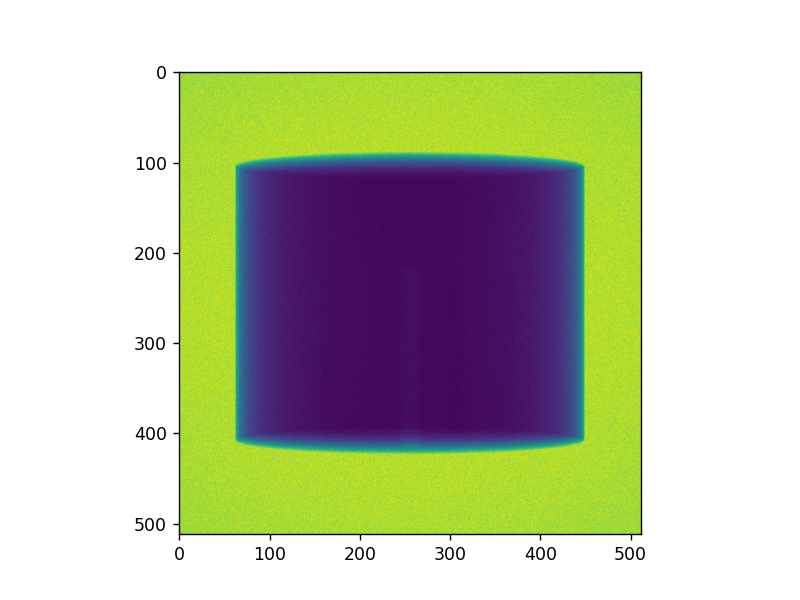

In [58]:
ggems_image, origin, space = load_itk('/home/jericho/1-Workspace/opengate_ggems_comparison/water_cylinder/run_edep_hit.mhd') # What is this in? - Should be MeV as well according to didier

plt.figure()
plt.imshow(ggems_image)

In [92]:
import spekpy as sp

In [99]:
spec = np.loadtxt('/home/jericho/1-Workspace/opengate_ggems_comparison/water_cylinder/data/spectrum_120kVp_2mmAl.dat')

<IPython.core.display.Javascript object>


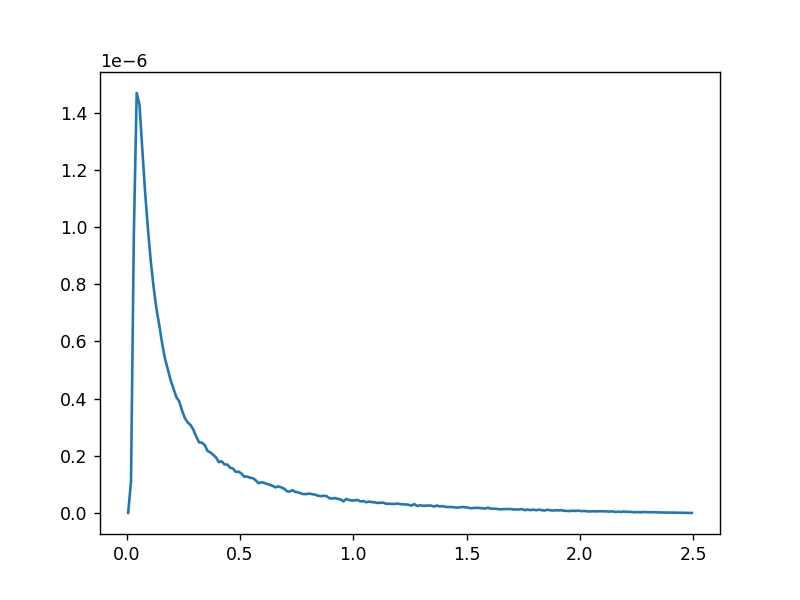

In [103]:
plt.figure()
plt.plot(spec[:,0],spec[:,1])

In [102]:
spec = np.loadtxt('/home/jericho/Software/fastcat/fastcat/data/MV_spectra/Al_spectrum_25.txt')